Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

Load data

In [2]:
columns_file = 'census-bureau.columns'
with open(columns_file, 'r') as f:
    columns = [line.strip() for line in f.readlines()]

print(f"Total columns: {len(columns)}")
print(f"Columns loaded: {columns}")

# Load data
data_file = 'census-bureau.data'
df = pd.read_csv(data_file, header=None, names=columns)

print(f"\nDataset shape: {df.shape}")

Total columns: 42
Columns loaded: ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", '

In [3]:
df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital stat                                199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

In [5]:
df['label'].value_counts()

label
- 50000.    187141
50000+.      12382
Name: count, dtype: int64

In [6]:
df['label'] = (df['label'] == '50000+.').astype(int)

In [7]:
df['label'].value_counts()

label
0    187141
1     12382
Name: count, dtype: int64

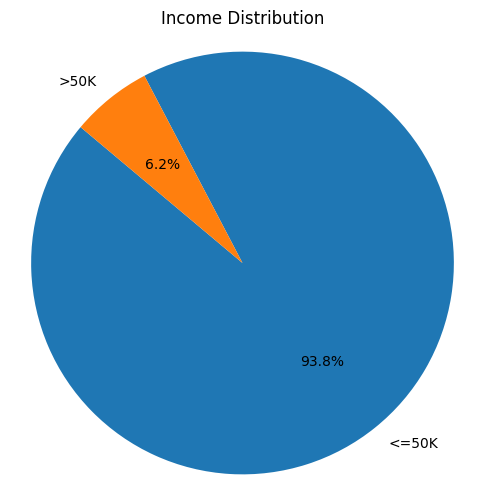

In [8]:
# draw pie chart of label distribution
labels = ['<=50K', '>50K']
sizes = df['label'].value_counts().values
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Income Distribution')
plt.axis('equal')
plt.show()

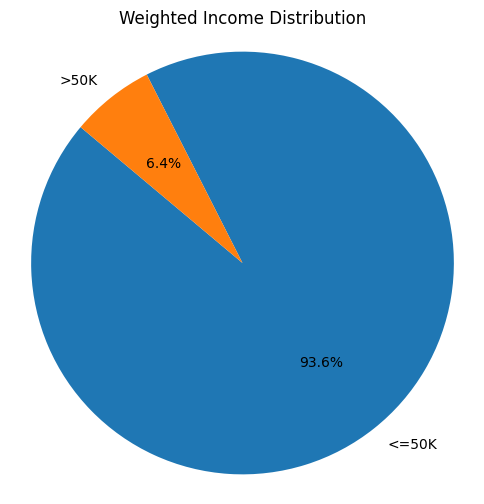

In [9]:
import matplotlib.pyplot as plt

# Weighted counts
weighted_counts = df.groupby('label')['weight'].sum()

labels = ['<=50K', '>50K']
sizes = weighted_counts.values

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Weighted Income Distribution')
plt.axis('equal')
plt.show()


So it is a imbalanced dataset

In [10]:
# find missing values
missing_values = df.isnull().sum()
missing_values

age                                             0
class of worker                                 0
detailed industry recode                        0
detailed occupation recode                      0
education                                       0
wage per hour                                   0
enroll in edu inst last wk                      0
marital stat                                    0
major industry code                             0
major occupation code                           0
race                                            0
hispanic origin                               874
sex                                             0
member of a labor union                         0
reason for unemployment                         0
full or part time employment stat               0
capital gains                                   0
capital losses                                  0
dividends from stocks                           0
tax filer stat                                  0


In [11]:
# percentage of missing values in hispanic_origin column
missing_percentage = (missing_values['hispanic origin'] / len(df)) * 100
print(f"Percentage of missing values in hispanic_origin: {missing_percentage:.2f}%")

Percentage of missing values in hispanic_origin: 0.44%


In [12]:
df['hispanic origin'].value_counts()

hispanic origin
All other                    171907
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Other Spanish                  2485
Cuban                          1126
Do not know                     306
Chicano                         304
Name: count, dtype: int64

percentage of missing values in hispanic origin column is very less 

In [13]:
df['hispanic origin'] = df['hispanic origin'].fillna('Do not know')


In [14]:
pd.crosstab(
    df['hispanic origin'],
    df['label'],
    normalize='index'
).sort_values(by=1, ascending=False)


label,0,1
hispanic origin,,
All other,0.931550,0.068450
Do not know,0.944915,0.055085
Cuban,0.945826,0.054174
Other Spanish,0.967404,0.032596
Mexican-American,0.978710,0.021290
Central or South American,0.979461,0.020539
Puerto Rican,0.979475,0.020525
Chicano,0.980263,0.019737
Mexican (Mexicano),0.988665,0.011335


there is huge disparity in the hispanic groups cannot make them 0/1

In [15]:
df.isna().sum()

age                                           0
class of worker                               0
detailed industry recode                      0
detailed occupation recode                    0
education                                     0
wage per hour                                 0
enroll in edu inst last wk                    0
marital stat                                  0
major industry code                           0
major occupation code                         0
race                                          0
hispanic origin                               0
sex                                           0
member of a labor union                       0
reason for unemployment                       0
full or part time employment stat             0
capital gains                                 0
capital losses                                0
dividends from stocks                         0
tax filer stat                                0
region of previous residence            

In [16]:
missing_qmark = (df == '?').sum()
missing_qmark[missing_qmark > 0]/len(df)*100


state of previous residence        0.354846
migration code-change in msa      49.967172
migration code-change in reg      49.967172
migration code-move within reg    49.967172
migration prev res in sunbelt     49.967172
country of birth father            3.364524
country of birth mother            3.066814
country of birth self              1.700556
dtype: float64

dropping the migration columns since most of them are nulls


In [17]:
df=df.drop(columns=['migration code-change in msa','migration code-change in reg','migration code-move within reg','migration prev res in sunbelt'],axis=1)

In [18]:
cols = [
    'state of previous residence',
    'country of birth father',
    'country of birth mother',
    'country of birth self'
]

baseline = df['label'].mean() * 100
print(f"Overall % label=1 (baseline): {baseline:.2f}%\n")

for col in cols:
    mask = df[col] == '?'
    pct = df.loc[mask, 'label'].mean() * 100
    count = mask.sum()
    
    print(f"{col}")
    print(f"  Count of '?': {count}")
    print(f"  % label=1 when '?': {pct:.2f}%\n")


Overall % label=1 (baseline): 6.21%

state of previous residence
  Count of '?': 708
  % label=1 when '?': 6.36%

country of birth father
  Count of '?': 6713
  % label=1 when '?': 8.18%

country of birth mother
  Count of '?': 6119
  % label=1 when '?': 7.66%

country of birth self
  Count of '?': 3393
  % label=1 when '?': 8.75%



will remove the ? rows for regression analysis but keep for decsion trees

In [19]:
# divide into categorical_cols and numerical_cols
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [20]:
# remove 'label' from numerical_cols
numerical_cols.remove('label')

In [21]:
# chk all numerics columns are they actually categorical?
numerical_cols

['age',
 'detailed industry recode',
 'detailed occupation recode',
 'wage per hour',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'weight',
 'num persons worked for employer',
 'own business or self employed',
 'veterans benefits',
 'weeks worked in year',
 'year']

In [22]:
# detailed industry recode

# detailed occupation recode

# own business or self employed

# veterans benefits

# year/* these columns are actually categorical, so we will move them to categorical_cols and remove from numerical_cols */
categorical_cols.extend(['detailed industry recode', 'detailed occupation recode', 'own business or self employed', 'veterans benefits', 'year'])
numerical_cols = [col for col in numerical_cols if col not in ['detailed industry recode', 'detailed occupation recode', 'own business or self employed', 'veterans benefits', 'year']]

In [23]:
df['year'].value_counts()

year
94    99827
95    99696
Name: count, dtype: int64

In [24]:
categorical_cols

['class of worker',
 'education',
 'enroll in edu inst last wk',
 'marital stat',
 'major industry code',
 'major occupation code',
 'race',
 'hispanic origin',
 'sex',
 'member of a labor union',
 'reason for unemployment',
 'full or part time employment stat',
 'tax filer stat',
 'region of previous residence',
 'state of previous residence',
 'detailed household and family stat',
 'detailed household summary in household',
 'live in this house 1 year ago',
 'family members under 18',
 'country of birth father',
 'country of birth mother',
 'country of birth self',
 'citizenship',
 "fill inc questionnaire for veteran's admin",
 'detailed industry recode',
 'detailed occupation recode',
 'own business or self employed',
 'veterans benefits',
 'year']

In [25]:
for col in categorical_cols:
    
    # Compute weighted income rate per category
    weighted_rate = df.groupby(col).apply(
        lambda x: (x['label'] * x['weight']).sum() / x['weight'].sum()
    )
    
    # Separation = max rate - min rate
    separation = weighted_rate.max() - weighted_rate.min()
    
    print(f"{col}: Weighted Separation = {separation:.4f}")


class of worker: Weighted Separation = 0.3608
education: Weighted Separation = 0.5389
enroll in edu inst last wk: Weighted Separation = 0.0676
marital stat: Weighted Separation = 0.1057
major industry code: Weighted Separation = 0.2972
major occupation code: Weighted Separation = 0.2873
race: Weighted Separation = 0.0511
hispanic origin: Weighted Separation = 0.0594
sex: Weighted Separation = 0.0765
member of a labor union: Weighted Separation = 0.0796
reason for unemployment: Weighted Separation = 0.0624
full or part time employment stat: Weighted Separation = 0.1160
tax filer stat: Weighted Separation = 0.1371
region of previous residence: Weighted Separation = 0.0363
state of previous residence: Weighted Separation = 0.1096
detailed household and family stat: Weighted Separation = 0.1540
detailed household summary in household: Weighted Separation = 0.1326
live in this house 1 year ago: Weighted Separation = 0.0280
family members under 18: Weighted Separation = 0.0873
country of bir

In [26]:
important_cols=['education','class of worker','major occupation code','marital stat','major industry code','own business or self employed']

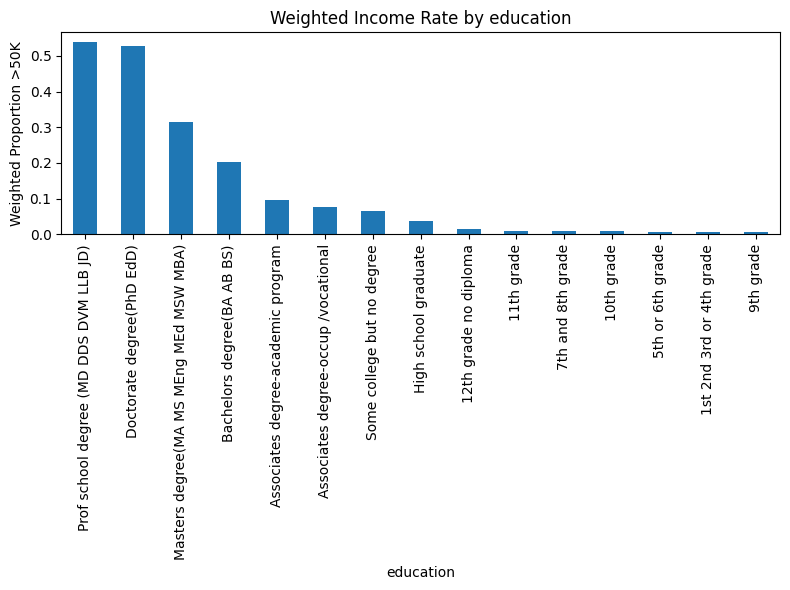

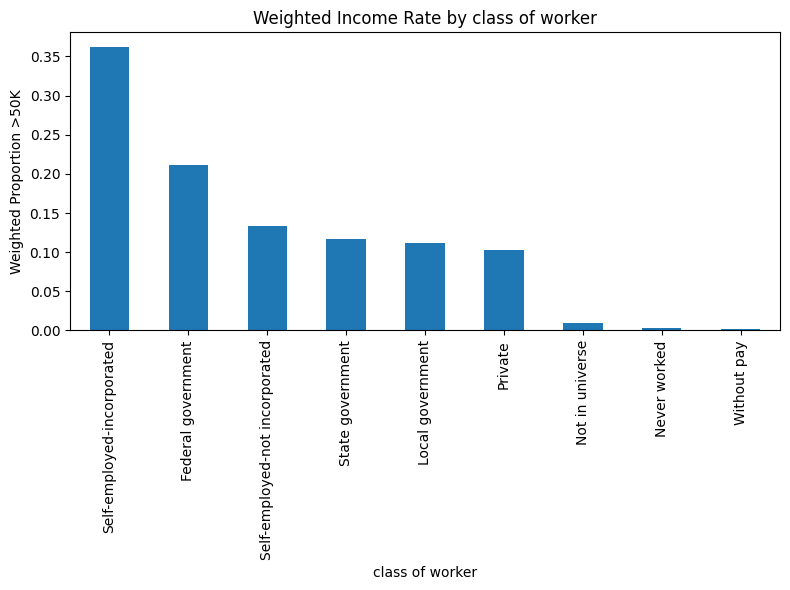

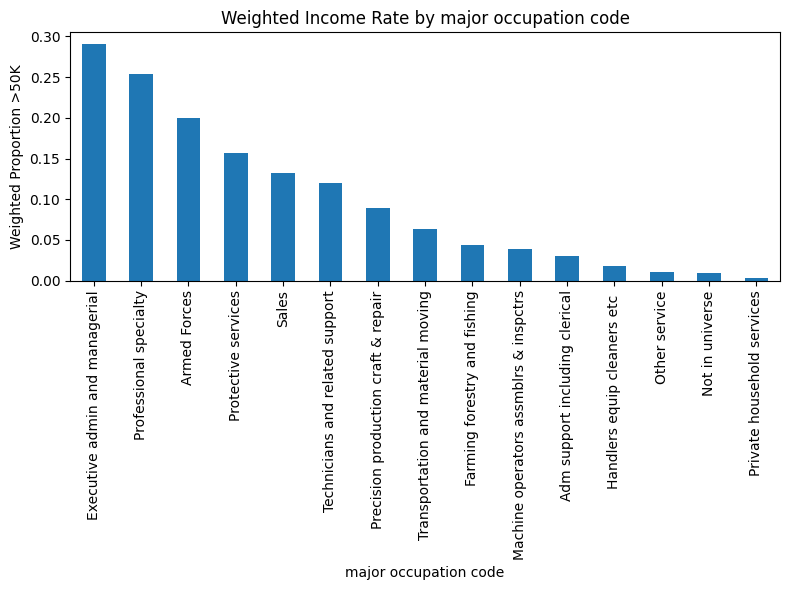

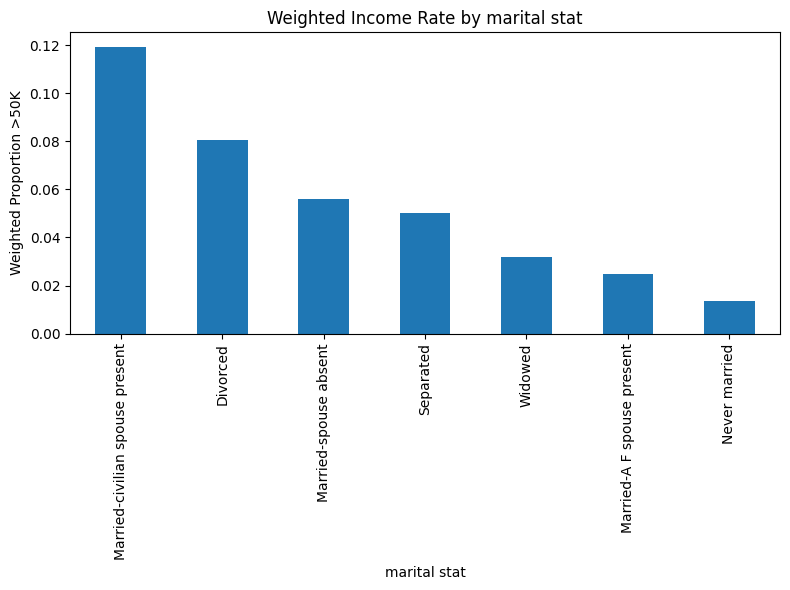

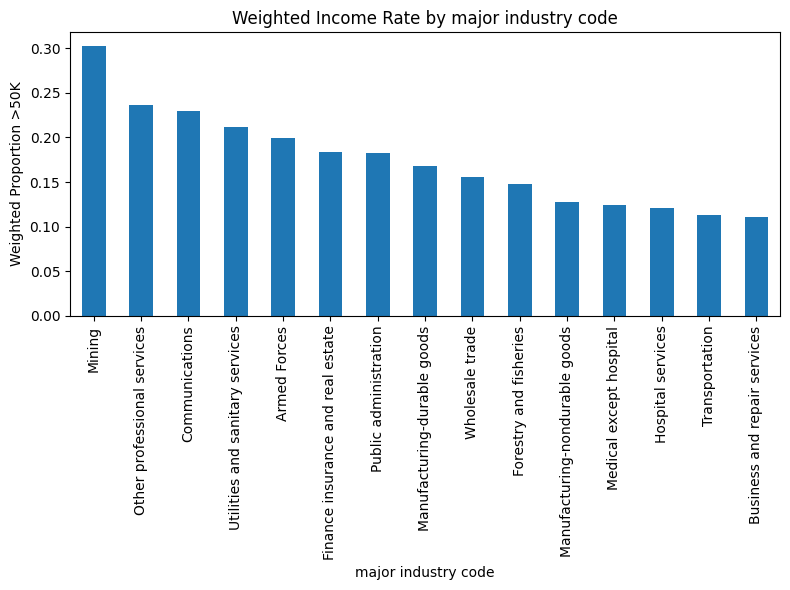

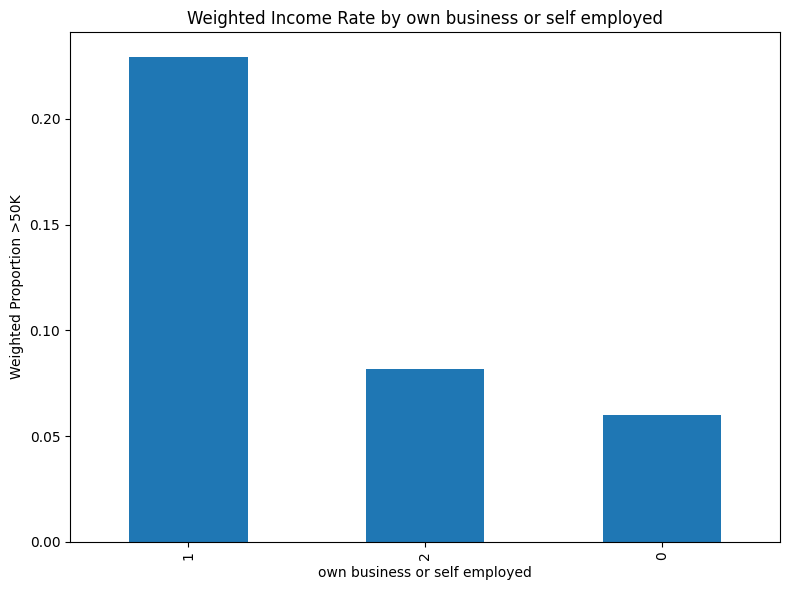

In [27]:
for col in important_cols:
    plt.figure(figsize=(8,6))
    
    rate = df.groupby(col).apply(
        lambda x: (x['label'] * x['weight']).sum() / x['weight'].sum()
    ).sort_values(ascending=False)
    
    rate.head(15).plot(kind='bar')
    plt.ylabel('Weighted Proportion >50K')
    plt.title(f'Weighted Income Rate by {col}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


# Exploratory Data Analysis – Key Insights

## 1. Education – Strongest Predictor

Education level shows a very strong positive relationship with income.

| Education Level | % Earning > $50K |
|-----------------|------------------|
| Prof school degree (MD/DDS) | ~55% |
| Doctorate degree | ~52% |
| Masters degree (MD/MSW/MBA) | ~32% |
| Bachelor's degree | ~20% |

### Key Insight
There is a clear income gradient: higher education levels are strongly associated with higher income probability.

### Implication
Education is one of the most important predictors of income and should be retained in modeling.

---

## 2. Class of Worker – Strong Differentiator

Employment classification significantly impacts income probability.

| Class of Worker | % Earning > $50K |
|-----------------|------------------|
| Self-employed (incorporated) | ~35% |
| Federal government | ~20% |
| Self-employed (not incorporated) | ~13% |
| State/Local government | ~12% |

### Key Insight
Self-employed incorporated individuals have significantly higher income probability.
Government workers show moderate income levels despite job stability.

### Implication
Class of worker is a strong categorical feature and should be included in the model.

---

## 3. Major Industry Code – Moderate Differentiator

Income varies meaningfully across industries.

| Industry | % Earning > $50K |
|----------|------------------|
| Mining | ~26% |
| Professional services | ~23% |
| Communications | ~23% |
| Armed Forces | ~22% |
| Manufacturing & Wholesale | ~17% |
| Business & Repair Services | ~12% |

### Key Insight
Certain industries (e.g., mining and professional services) exhibit substantially higher income rates.

### Implication
Industry classification contributes meaningful predictive information.

---

## 4. Major Occupation Code – Important Predictor

Occupation category shows clear income hierarchy.

| Occupation | % Earning > $50K |
|------------|------------------|
| Executive/Administrative/Managerial | ~29% |
| Professional Specialty | ~25% |
| Armed Forces | ~23% |
| Sales | ~16% |
| Blue-collar roles | ~2–5% |

### Key Insight
Managerial and professional roles are strongly associated with higher income.
Blue-collar occupations exhibit significantly lower high-income rates.

### Implication
Occupation is a structurally important income determinant.

---

## 5. Detailed Industry & Occupation – Highest Granularity

Detailed categories provide sharper income separation.

| Category | % Earning > $50K |
|----------|------------------|
| Detailed Industry Code 20 | ~50% |
| Detailed Occupation Code 7 | ~68% |
| Detailed Occupation Code 11 | ~65% |

### Key Insight
Detailed occupation codes show extremely strong income differentiation.
These granular features outperform broad categories in predictive separation.

### Implication
Detailed occupation and industry variables are powerful predictors but may require careful encoding to avoid overfitting.

---

## 6. Self-Employment Status – Strong Binary Signal

| Self-Employment Status | % Earning > $50K |
|------------------------|------------------|
| Self-employed | ~23% |
| Not self-employed | ~6% |

### Key Insight
Self-employed individuals are nearly 4 times more likely to earn above $50K compared to non-self-employed individuals.

### Implication
Self-employment status is a highly informative binary feature.

---

# Overall EDA Conclusion

Income in this dataset is primarily driven by:

1. Education level  
2. Occupation type  
3. Industry sector  
4. Self-employment status  

Demographic variables (race, Hispanic origin, year) exhibit relatively weak separation and are likely secondary predictors.

This suggests that structural employment and education factors dominate income prediction in this dataset.


In [28]:
numerical_cols.remove('weight')


In [29]:
numerical_cols

['age',
 'wage per hour',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'num persons worked for employer',
 'weeks worked in year']

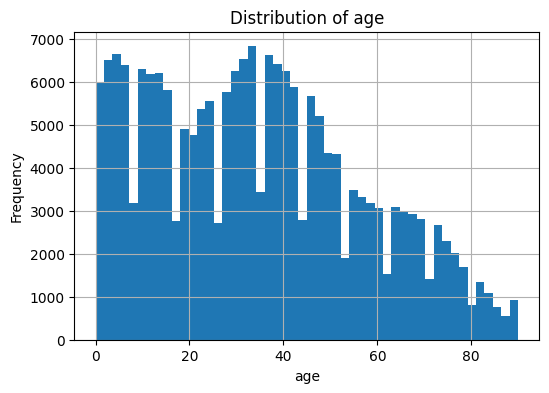

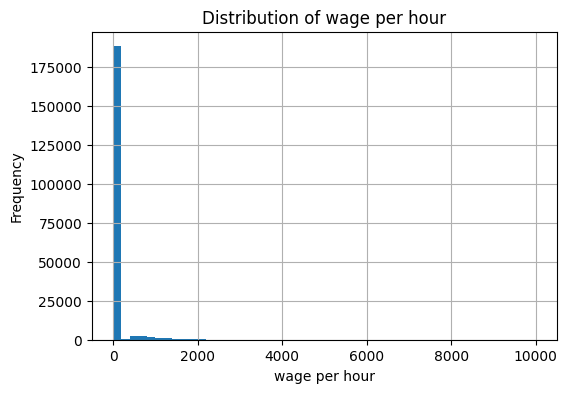

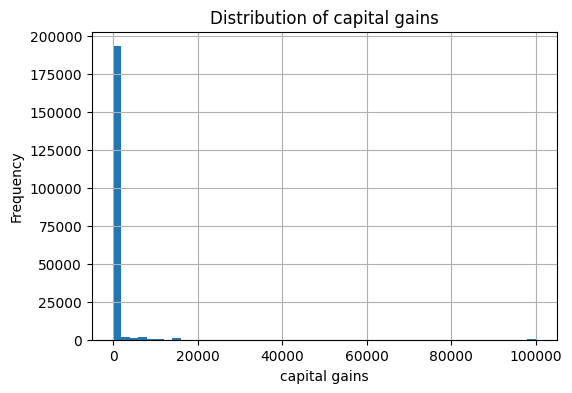

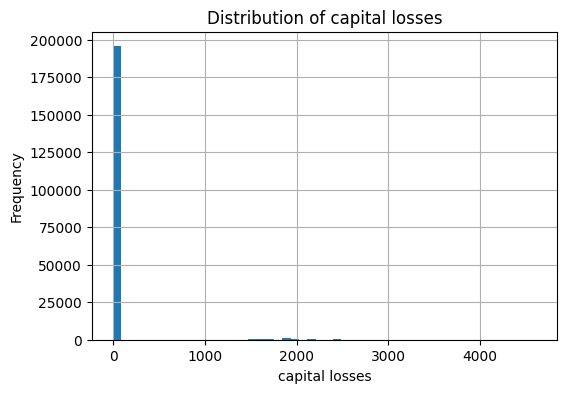

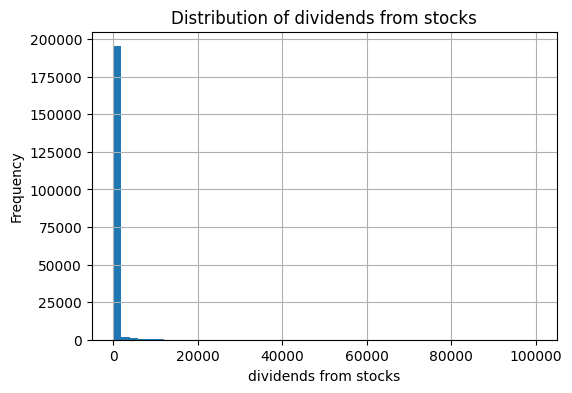

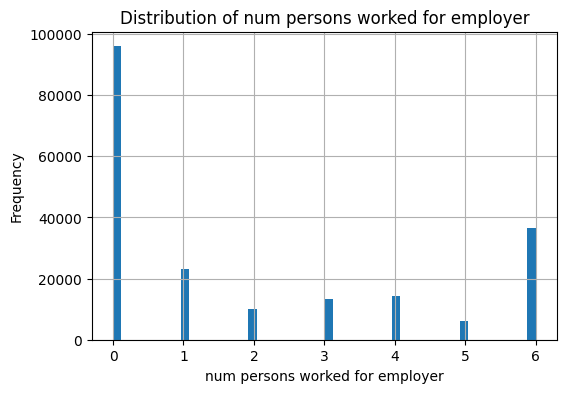

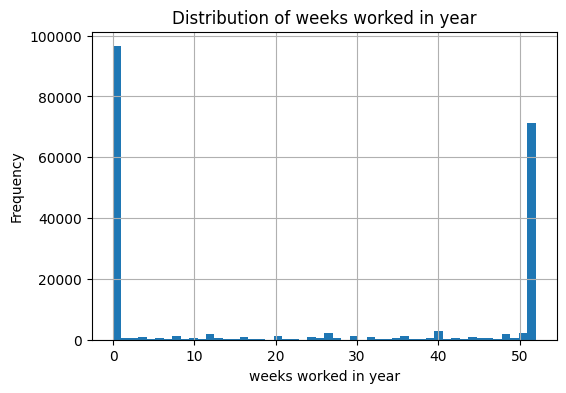

In [30]:
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    df[col].hist(bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


apart from age num persons and weeks worked mos of them are skewed

In [31]:
# import numpy as np

# skewed_cols = [
#     'wage per hour',
#     'capital gains',
#     'capital losses',
#     'dividends from stocks'
# ]

# for col in skewed_cols:
#     df[col] = np.log1p(df[col])


I checked the disctrubtion for the skewed columns after log trabnsformation but not much chnage since mot of them are 0's


Weighted Numerical Feature Comparison:
                                 Weighted Low (≤50K)  Weighted High (>50K)  \
capital gains                             144.574620           4781.242068   
dividends from stocks                     109.484703           1483.940367   
capital losses                             27.872649            194.792756   
weeks worked in year                       21.900271             48.163953   
wage per hour                              55.723077             81.373316   
age                                        33.676008             46.129831   
num persons worked for employer             1.876119              4.028065   

                                 Weighted Mean Difference  
capital gains                                 4636.667448  
dividends from stocks                         1374.455664  
capital losses                                 166.920107  
weeks worked in year                            26.263682  
wage per hour                      

<Figure size 600x400 with 0 Axes>

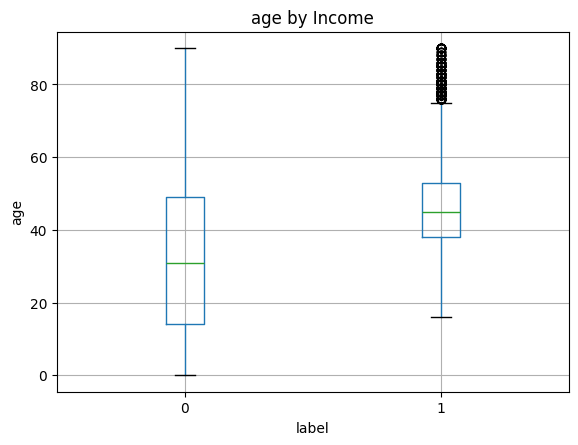

<Figure size 600x400 with 0 Axes>

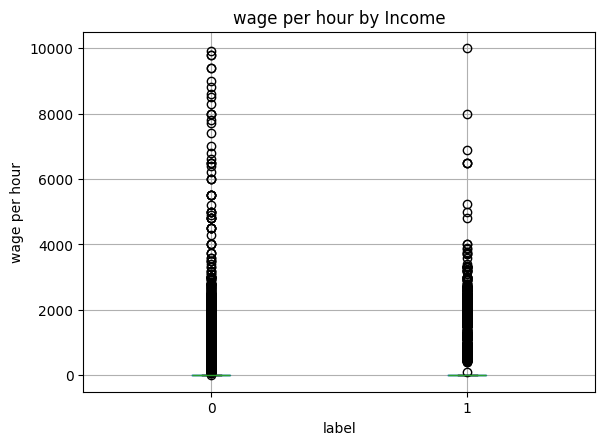

<Figure size 600x400 with 0 Axes>

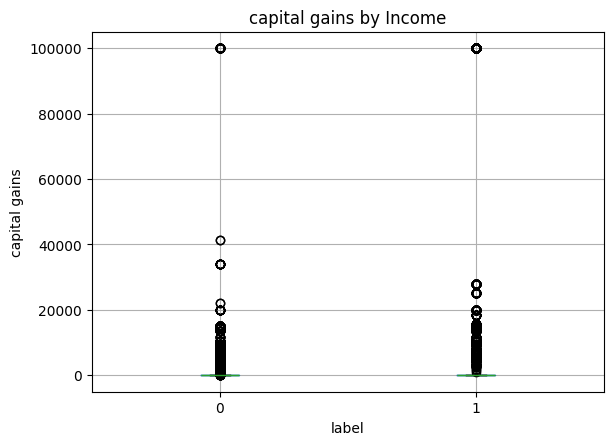

<Figure size 600x400 with 0 Axes>

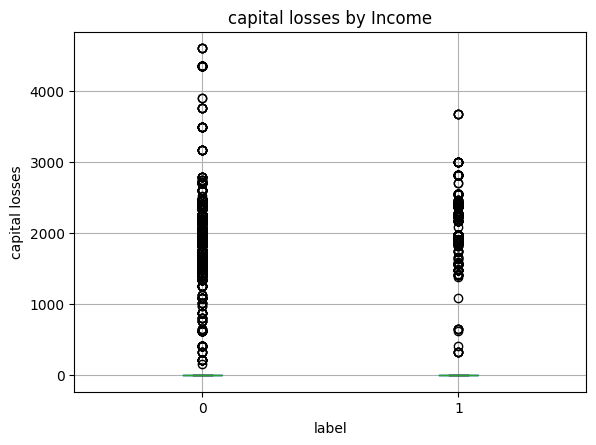

<Figure size 600x400 with 0 Axes>

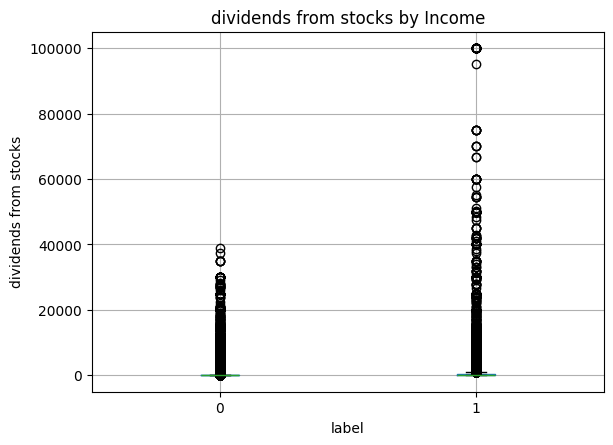

<Figure size 600x400 with 0 Axes>

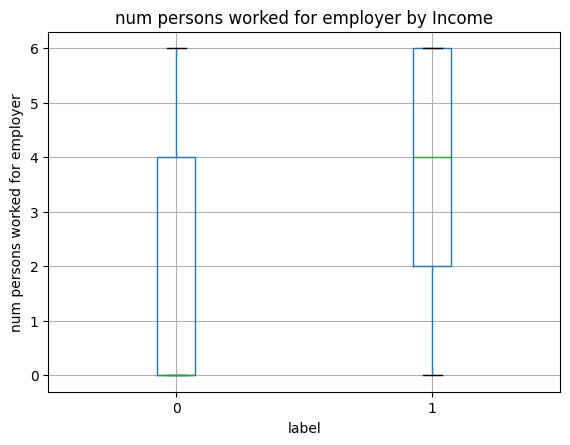

<Figure size 600x400 with 0 Axes>

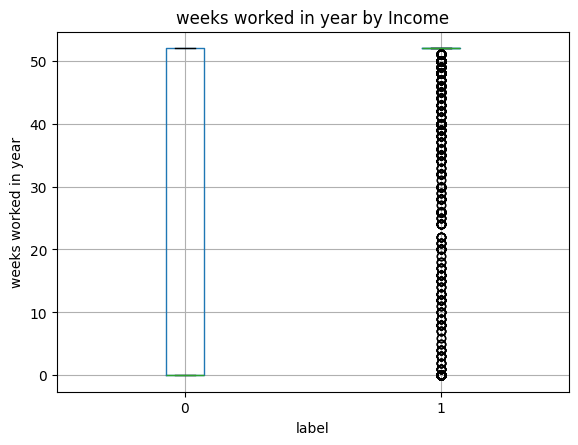

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Compute weighted mean comparison + difference
weighted_means = {}

for col in numerical_cols:
    
    low = df[df['label'] == 0]
    high = df[df['label'] == 1]
    
    weighted_low = np.sum(low[col] * low['weight']) / np.sum(low['weight'])
    weighted_high = np.sum(high[col] * high['weight']) / np.sum(high['weight'])
    
    weighted_means[col] = {
        'Weighted Low (≤50K)': weighted_low,
        'Weighted High (>50K)': weighted_high,
        'Weighted Mean Difference': weighted_high - weighted_low
    }

weighted_means_df = pd.DataFrame(weighted_means).T
weighted_means_df = weighted_means_df.sort_values(
    by='Weighted Mean Difference',
    ascending=False
)

print("\nWeighted Numerical Feature Comparison:")
print(weighted_means_df)


# 2️⃣ Boxplots (still unweighted — fine for visualization)
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    df.boxplot(column=col, by='label')
    plt.title(f'{col} by Income')
    plt.suptitle('')
    plt.ylabel(col)
    plt.show()


## Comprehensive EDA Analysis - Numerical Features

### **Summary of 8 Numerical Features**

#### **1. INVESTMENT INCOME FEATURES (VERY STRONG PREDICTORS)**

**Capital Gains**
- **Mean for ≤$50K**: $145 | **Mean for >$50K**: $4,781
- **Difference**: +$4,637 (**32x higher!**)
- **Pattern**: Heavily zero-inflated (95%+ zeros). Those with ANY capital gains are much more likely to earn >$50K
- **Insight**: Having investment income is a strong income indicator

**Dividends from Stocks**
- **Mean for ≤$50K**: $109 | **Mean for >$50K**: $1,484
- **Difference**: +$1,374 (**13.5x higher!**)
- **Pattern**: Similar zero-inflation. High-income earners receive significantly more dividends
- **Insight**: Passive income is strongly associated with high income

**Capital Losses**
- **Mean for ≤$50K**: $28 | **Mean for >$50K**: $195
- **Difference**: +$167 (**6.5x higher**)
- **Pattern**: Rare, but those with losses tend to have higher incomes (they trade more)
- **Insight**: Active investing signal correlates with income

**→ Combined Recommendation**: Create binary features for "has capital gains", "has dividends", "has losses" for better predictive power

---

#### **2. WORK-RELATED FEATURES (STRONG PREDICTORS)**

**Weeks Worked in Year**
- **Mean for ≤$50K**: 22 weeks | **Mean for >$50K**: 48 weeks
- **Difference**: +26 weeks (**120% more!**)
- **Pattern**: Clear separation - high earners work significantly more full year (50+ weeks), low earners have many part-time/seasonal workers
- **Insight**: Full-time employment is essential for high income
- **Strength**: VERY STRONG predictor

**Wage per Hour**
- **Mean for ≤$50K**: $56/hr | **Mean for >$50K**: $81/hr
- **Difference**: +$26/hr (**46% higher**)
- **Pattern**: Continuous distribution with clear separation between groups
- **Insight**: Hourly wage directly correlates with income tier
- **Strength**: STRONG predictor

---

#### **3. JOB LEVEL FEATURE (MODERATE PREDICTOR)**

**Number of Persons Worked for Employer**
- **Mean for ≤$50K**: 1.88 | **Mean for >$50K**: 4.03
- **Difference**: +2.15 (**115% larger organizations**)
- **Pattern**: Low-income workers in small companies (1-2 people); high-income workers in larger organizations
- **Insight**: Company size correlates with salary levels
- **Strength**: MODERATE predictor

---

#### **4. AGE (STRONG PREDICTOR)**

**Age**
- **Mean for ≤$50K**: 34 years | **Mean for >$50K**: 46 years
- **Difference**: +12 years (**37% older**)
- **Pattern**: Clear separation, high-income workers median ~45, low-income ~33
- **Insight**: Experience/seniority increases income significantly
- **Strength**: STRONG predictor
- **Note**: Age likely a proxy for experience and career progression

---

### **Feature Importance Ranking (Numerical)**

| Rank | Feature | Predictive Power | Why |
|------|---------|------------------|-----|
| 1 | **Capital Gains** | VERY STRONG | 32x difference between groups |
| 2 | **Dividends** | VERY STRONG | 13.5x difference between groups |
| 3 | **Weeks Worked** | VERY STRONG | 120% more for high earners |
| 4 | **Wage per Hour** | STRONG | 46% higher for high earners |
| 5 | **Age** | STRONG | 37% older for high earners |
| 6 | **Capital Losses** | MODERATE | 6.5x difference |
| 7 | **Num Persons Employer** | MODERATE | 115% larger orgs |

---

### **Key Insights**

✅ **Investment Income is the #1 Signal**
- Capital gains and dividends have 32x and 13.5x differences respectively
- Having ANY investment income → 4-5x probability increase of >$50K

✅ **Full-Time Work Matters**
- 48 weeks vs 22 weeks is the clearest employment signal
- Part-time work almost guarantees ≤$50K income

✅ **Experience + Salary Progression**
- Older workers earn more (age = proxy for experience)
- Larger companies pay more (company size correlates with salary)

✅ **Continuous Variables Show Clear Separation**
- No overlap at extremes (age 18-25 almost never >$50K, age 50+ more likely >$50K)
- Wage tiers clearly define income groups


---

### **For Modeling**

**Feature Engineering Recommendations:**
1. Keep raw values (for tree models)
2. Create binary flags:
   - `has_capital_gains = 1 if capital_gains > 0 else 0`
   - `has_dividends = 1 if dividends > 0 else 0`
   - `has_losses = 1 if capital_losses > 0 else 0`
3. Drop `weight` column
4. Consider age bins if using linear models
5. Keep `weeks_worked` as is (strong continuous signal)

## Recommendations for Categorical Variables

### **Overview of 28 Categorical Features**

Based on cardinality and predictive strength from EDA, here's the encoding strategy:

---

### **TIER 1: Strong Predictors (ENCODE WITH CARE)**

These features have **high predictive power** and clear income separation:

| Feature | Cardinality | Strategy | Why |
|---------|-------------|----------|-----|
| **education** | ~16 values | Ordinal encode | Clear gradient: HS < Bachelor < Masters < PhD |
| **class of worker** | ~9 values | One-hot encode | Self-employed has 35% high-income rate |
| **detailed occupation recode** | ~22 values | Target encode | 68% variation (occupation 7 → 68%, occupation 8 → 18%) |
| **detailed industry recode** | ~22 values | Target encode | 50% variation in high-income rates |
| **major occupation code** | ~15 values | One-hot encode | Executive/professional vs blue-collar separation clear |
| **major industry code** | ~15 values | One-hot encode | Mining/professional services vs service industry |
| **own business or self employed** | 3 values | One-hot encode (2 dummies) | Self-employed: 23%, employee: 6% |
| **marital stat** | ~6 values | One-hot encode | Married earners > single earners |
| **sex** | 2 values | Binary encode | Male/Female should be binary (0/1) |

**Encoding Recommendation for Tier 1:**
- ✅ Use **ordinal encoding** for education (has natural ordering)
- ✅ Use **one-hot encoding** for binary/few-value features (sex, self-employed, class of worker)
- ✅ Use **target encoding** for high-cardinality features (occupations, industries)
  - *Why target encoding?* It captures predictive power without creating too many columns
  - *How?* Map each category value to mean(target) for that category
  - *Important:* Use cross-validation or separate validation set to avoid leakage!

---

### **TIER 2: Moderate Predictors (STANDARD ENCODING)**

These have moderate predictive power:

| Feature | Cardinality | Strategy | Notes |
|---------|-------------|----------|-------|
| **race** | ~6 values | One-hot encode | Some income variation, multiple categories |
| **hispanic origin** | ~3 values | One-hot encode | Few missing values, clear categories |
| **tax filer stat** | ~5 values | One-hot encode | Financial status indicator |
| **enroll in edu inst last wk** | ~3 values | One-hot encode | Binary-like feature |
| **member of labor union** | ~3 values | One-hot encode | Employment status signal |

**Encoding Recommendation for Tier 2:**
- ✅ Use **one-hot encoding** for all these
- ✅ Drop one category per feature to avoid multicollinearity (with tree models, this is optional)

---

### **TIER 3: Weak/Exploratory Predictors (USE CAUTIOUSLY)**

These have low to moderate predictive value:

| Feature | Cardinality | Strategy | Action |
|---------|-------------|----------|--------|
| **full or part time employment stat** | ~3 values | One-hot encode | Correlated with weeks worked (may be redundant) |
| **reason for unemployment** | ~6 values | One-hot encode | Only applies to unemployed subset (~5% of data) |
| **region of previous residence** | ~4 values | One-hot encode | Migration patterns - weak signal |
| **state of previous residence** | ~50+ values | GROUP or TARGET encode | Too high cardinality, aggregate to regions |
| **migration code-*** (5 variants) | ~3 values each | One-hot encode | All migration-related are weak, consider dropping |
| **live in this house 1 year ago** | ~3 values | One-hot encode | Weak mobility signal |
| **migration prev res in sunbelt** | ~3 values | One-hot encode | Geographic indicator, weak |
| **family members under 18** | ~5 values | Ordinal encode | Few family members → better income? (weak) |
| **country of birth (father/mother/self)** | ~90 values each | TARGET encode or DROP | Very high cardinality, only keep if needed |
| **citizenship** | ~5 values | One-hot encode | Maybe relevant, check for VISA/citizenship signal |
| **fill inc questionnaire for veteran's admin** | ~3 values | One-hot encode | Proxy for veteran status |
| **veterans benefits** | ~3 values | One-hot encode | Veteran indicator, keep for identity features |
| **detailed household and family stat** | ~20 values | One-hot or GROUP | Complex feature, consider grouping |
| **detailed household summary in household** | ~10 values | One-hot encode | Family composition indicator |

**Encoding Recommendation for Tier 3:**
- ⚠️ Most of these are weak predictors
- ✅ Use **one-hot encoding** if you keep them
- 🚫 **Consider dropping**: all migration codes, state of residence (replace with region), country of birth (too sparse)
- ✅ **Keep**: veteran status, family status (might capture patterns)

---

### **SPECIAL CASES**

**"Year" Column (already in numerical_cols):**
- ✅ Already handled as numeric (1994 vs 1995)
- Keep as-is, it's a simple binary year indicator

**Cardinality Issues:**
- Features like `state of previous residence` (50+ values) or `country of birth` (90+ values) create too many dummy variables
- **Solutions:**
  1. **Target encoding**: Map to mean income probability
  2. **Grouping**: Combine similar states/countries
  3. **Drop**: If weak signal

---



In [33]:
# create a copy of df
data=df

In [34]:
from traitlets import This


print("=" * 100)
print("COMPREHENSIVE DATA ENGINEERING: NUMERIC + CATEGORICAL")
print("=" * 100)

# ============================================================================
# STEP 1: NUMERIC FEATURE ENGINEERING
# ============================================================================
print("\n✓ STEP 1: NUMERIC FEATURE ENGINEERING")
print("-" * 100)


# Create binary flags for zero-inflated investment income columns
investment_cols = ['capital gains', 'capital losses', 'dividends from stocks']
for col in investment_cols:
    if col in df.columns:
        df[f'{col}_flag'] = (df[col] > 0).astype(int)
        print(f"  • Created '{col}_flag' (1 = has income, 0 = no income)")

print(f"\n  ✓ Numeric features after engineering: {len(numerical_cols)} features")
print(f"  ✓ Added {len(investment_cols)} binary flags for investment income")

# ============================================================================
# STEP 2: CATEGORICAL FEATURE ENGINEERING
# ============================================================================
print("\n✓ STEP 2: CATEGORICAL FEATURE ENGINEERING")
print("-" * 100)

# Define features to keep/encode
features_to_drop = [
    'state of previous residence',  # Too high cardinality
    'country of birth father',  # Too sparse
    'country of birth mother',  # Too sparse
    'migration code-change in msa',  # Weak signal
    'migration code-change in reg',  # Weak signal
    'migration code-move within reg',  # Weak signal
    'migration prev res in sunbelt',  # Weak signal
]

# Drop weak features
for col in features_to_drop:
    if col in df.columns:
        df = df.drop(col, axis=1)
        categorical_cols.remove(col) if col in categorical_cols else None

print(f"  • Dropped {len(features_to_drop)} weak/sparse features")
# ---- TIER 1: One-Hot Encode (Low Cardinality) ---- 
# one_hot_features = [ 'sex', 'race', 'hispanic origin', 'marital stat', 'enroll in edu inst last wk', 'member of a labor union', 'class of worker', 'own business or self employed', 'full or part time employment stat', 'tax filer stat', 'veterans benefits', "fill inc questionnaire for veteran's admin" ] 
# one_hot_features = [col for col in one_hot_features if col in df.columns] if one_hot_features: df_one_hot = pd.get_dummies(df[one_hot_features], drop_first=False) df = pd.concat([df.drop(one_hot_features, axis=1), df_one_hot], axis=1) print(f" • One-hot encoded {len(one_hot_features)} features") print(f" ({one_hot_features})")

# ---- TIER 2: Ordinal Encode Education (Natural Ordering) ----
education_map = {
    'Children': 0,
    'Less than 1st grade': 1,
    '1st 2nd 3rd or 4th grade': 2,
    '5th or 6th grade': 3,
    '7th and 8th grade': 4,
    '9th grade': 5,
    '10th grade': 6,
    '11th grade': 7,
    '12th grade no diploma': 8,
    'High school graduate': 9,
    'Some college but no degree': 10,
    'Some college no degree': 10,
    'Some college but no degree ': 10,
    'Associates degree-academic program': 11,
    'Associates degree-occup /vocational': 12,
    'Associates degree-occupational /vocational': 12,
    'Associates degree-nursing': 12,
    'Bachelors degree(BA AB BS)': 13,
    'Bachelors degree(BA BS)': 13,
    'Bachelors degree (BA AB BS)': 13,
    'Masters degree(MA MS MEng MEd MSW MBA)': 14,
    'Prof school degree (MD DDS DVM LLB JD)': 15,
    'Prof school degree(MD DDS DVM LLB JD)': 15,
    'Doctorate degree(PhD EdD)': 16,
    'Doctorate degree(PhD)': 16
}
df['education'] = df['education'].map(education_map)
print(f"  • Ordinal encoded 'education' (1-16 scale, low to high)")



# ============================================================================
# STEP 3: FINAL DATASET SUMMARY
# ============================================================================
print("\n" + "=" * 100)
print("✓ DATA ENGINEERING COMPLETE")
print("=" * 100)

print(f"\nDataset Shape: {df.shape}")
print(f"  • Rows: {df.shape[0]:,}")
print(f"  • Columns: {df.shape[1]:,}")

print(f"\nFeature Breakdown:")
print(f"  • Numeric features: {len(numerical_cols)} (age, wage, weeks worked, etc.)")
print(f"  • Binary flags: {len(investment_cols)} (investment income indicators)")
print(f"  • Encoded categorical: ~{df.shape[1] - len(numerical_cols) - len(investment_cols) - 1} (one-hot + target encoded)")

print(f"\nData Types:")
print(f"  • Numeric: {df.select_dtypes(include=['int64', 'float64']).shape[1]}")
print(f"  • Remaining features ready for modeling: {df.shape[1] - 1} (excluding label)")

print(f"\nMissing Values:")
print(f"  • Total missing: {df.isnull().sum().sum()}")

print("\n✓ Ready for train-test split and model training!")


COMPREHENSIVE DATA ENGINEERING: NUMERIC + CATEGORICAL

✓ STEP 1: NUMERIC FEATURE ENGINEERING
----------------------------------------------------------------------------------------------------
  • Created 'capital gains_flag' (1 = has income, 0 = no income)
  • Created 'capital losses_flag' (1 = has income, 0 = no income)
  • Created 'dividends from stocks_flag' (1 = has income, 0 = no income)

  ✓ Numeric features after engineering: 7 features
  ✓ Added 3 binary flags for investment income

✓ STEP 2: CATEGORICAL FEATURE ENGINEERING
----------------------------------------------------------------------------------------------------
  • Dropped 7 weak/sparse features
  • Ordinal encoded 'education' (1-16 scale, low to high)

✓ DATA ENGINEERING COMPLETE

Dataset Shape: (199523, 38)
  • Rows: 199,523
  • Columns: 38

Feature Breakdown:
  • Numeric features: 7 (age, wage, weeks worked, etc.)
  • Binary flags: 3 (investment income indicators)
  • Encoded categorical: ~27 (one-hot + target 

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k-1, r-1))))

categorical_cols = df.select_dtypes(include='object').columns

cramers_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramers_matrix = cramers_matrix.astype(float)


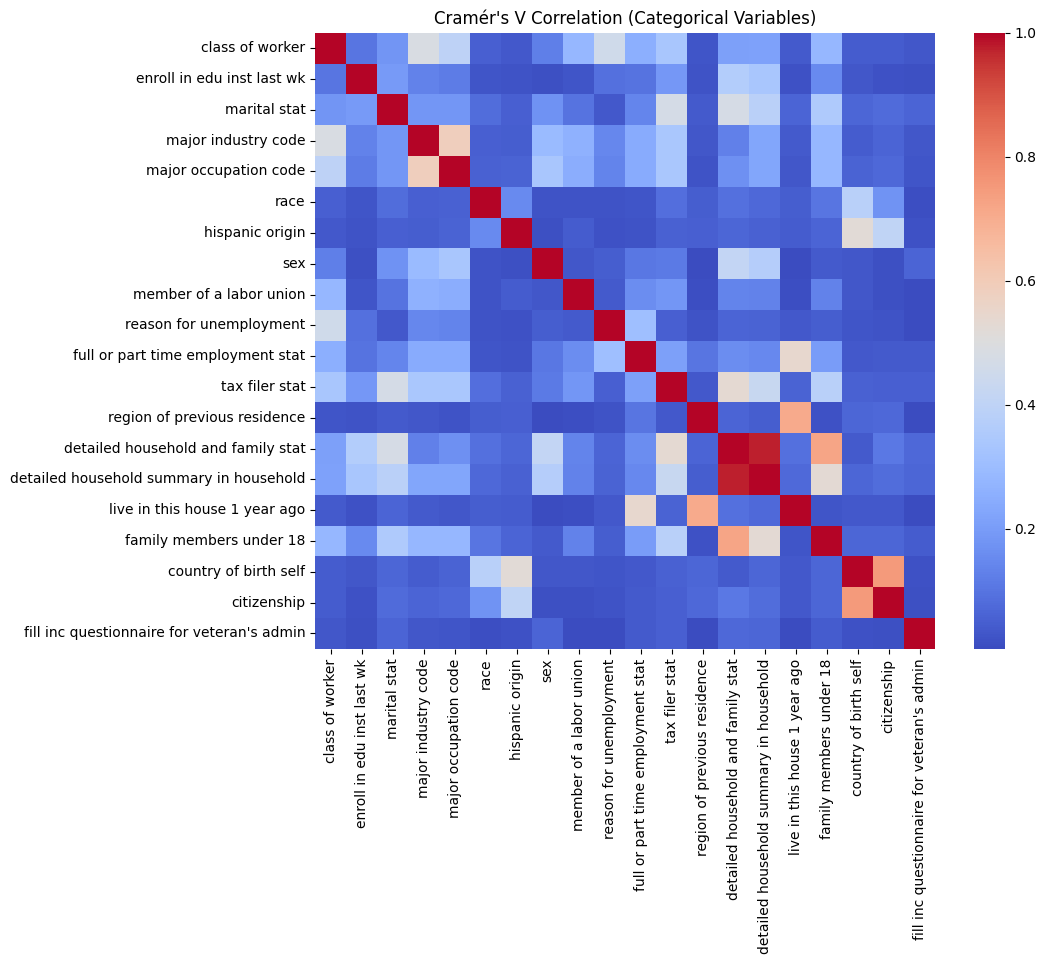

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cramers_matrix, annot=False, cmap='coolwarm')
plt.title("Cramér's V Correlation (Categorical Variables)")
plt.show()


1️⃣ Major Industry Code vs Major Occupation Code

Strong correlation

Industry influences occupation distribution.

Occupation more directly determines wage hierarchy.

Decision:

✅ Keep: major occupation code

❌ Drop: major industry code

Reason: Occupation is a more direct driver of income differences.

2️⃣ Class of Worker vs Own Business or Self Employed

Strong correlation

Self-employment status is already captured in class of worker.

Decision:

✅ Keep: class of worker

❌ Drop: own business or self employed

Reason: Class of worker contains richer employment structure information.

3️⃣ Detailed Household and Family Stat vs Detailed Household Summary in Household

Very strong correlation

Both describe household composition.

Highly redundant.

Decision:

✅ Keep: detailed household and family stat

❌ Drop: detailed household summary in household

Reason: Avoid multicollinearity and redundant household structure variables.

4️⃣ Country of Birth Self vs Citizenship

Strong correlation

Foreign-born status strongly linked with citizenship.

Decision:

✅ Keep: citizenship

❌ Drop: country of birth self

Reason: Citizenship directly affects labor market access and earning potential.

In [37]:
selected_categorical = [
    'class of worker',
    'major occupation code',
    'marital stat',
    'sex',
    'race',
    'hispanic origin',
    'tax filer stat',
    'full or part time employment stat',
    'detailed household and family stat',
    'family members under 18',
    'live in this house 1 year ago',
    'citizenship'
]


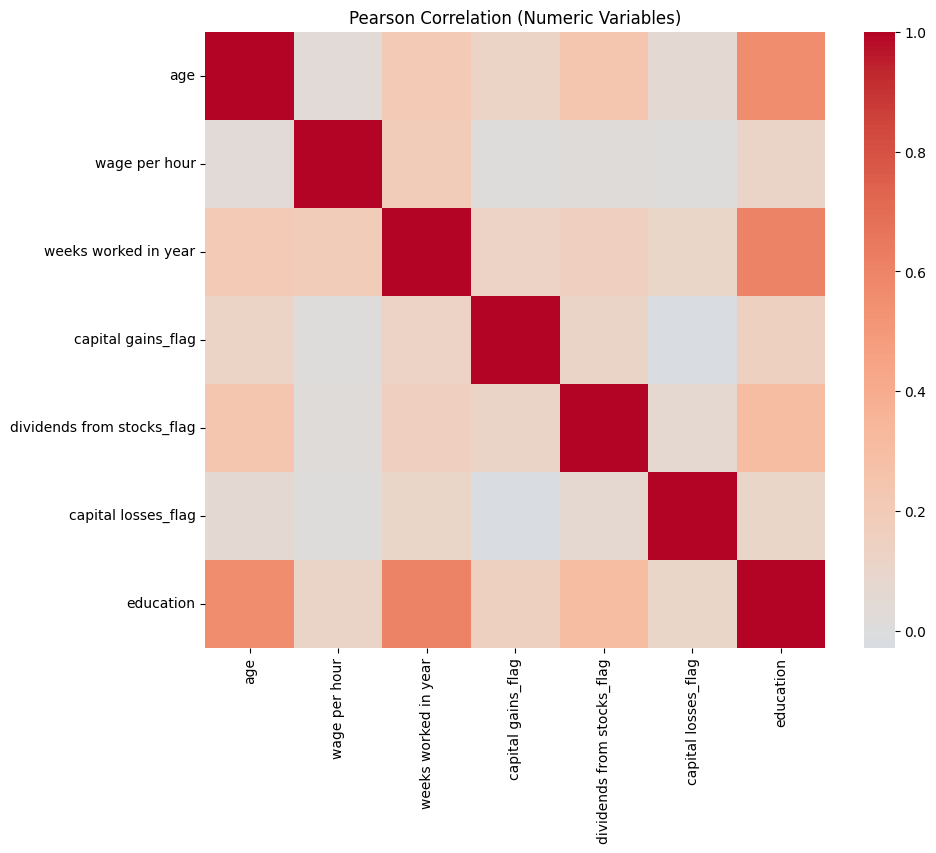

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns only
numeric_cols = ['age',
    'wage per hour',
    'weeks worked in year',
    'capital gains_flag',
    'dividends from stocks_flag',
    'capital losses_flag',
    'education']


# Remove label if included
numeric_cols = numeric_cols.drop('label') if 'label' in numeric_cols else numeric_cols

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Pearson Correlation (Numeric Variables)")
plt.show()


In [39]:
import pandas as pd
import statsmodels.api as sm

# ---------------------------
# 1️⃣ Select Strong Features
# ---------------------------

selected_numeric = [
    'age',
    'wage per hour',
    'weeks worked in year',
    'capital gains_flag',
    'dividends from stocks_flag',
    'capital losses_flag',
    'education'
]

selected_categorical = [
    'class of worker',
    'major occupation code',
    'marital stat',
    'sex'
]

# Keep only needed columns + label
df_model = df[selected_numeric + selected_categorical + ['label']].copy()

df_model = df_model[~df_model.isin(['?']).any(axis=1)]


# ---------------------------
# 2️⃣ One-hot encode categoricals
# ---------------------------

df_model = pd.get_dummies(
    df_model,
    columns=selected_categorical,
    drop_first=True   # avoids dummy trap
)

# ---------------------------
# 3️⃣ Define X and y
# ---------------------------



X = df_model.drop('label', axis=1)
y = df_model['label']

X = X.astype(float)
y = y.astype(float)


# Add intercept
X = sm.add_constant(X)

# ---------------------------
# 4️⃣ Fit Logistic Regression
# ---------------------------

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())



Optimization terminated successfully.
         Current function value: 0.133122
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               199523
Model:                          Logit   Df Residuals:                   199486
Method:                           MLE   Df Model:                           36
Date:                Sat, 14 Feb 2026   Pseudo R-squ.:                  0.4277
Time:                        00:01:59   Log-Likelihood:                -26561.
converged:                       True   LL-Null:                       -46408.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const    

selected_numeric = [
    'age',
    'wage per hour',
    'weeks worked in year',
    'capital gains_flag',
    'dividends from stocks_flag',
    'capital losses_flag',
    'education'
]


In [40]:
import pandas as pd
import statsmodels.api as sm


selected_numeric = [
    'age',
    'wage per hour',
    'weeks worked in year',
    'capital gains_flag',
    'dividends from stocks_flag',
    'capital losses_flag',
    'education'
]

selected_categorical = [
    'class of worker',
    'major occupation code',
    'marital stat',
    'sex',
    'race',
    'hispanic origin',
    'tax filer stat',
    'full or part time employment stat',
    'detailed household and family stat',
    'family members under 18',
    'live in this house 1 year ago',
    'citizenship'
]


# Keep only needed columns + label
df_model = df[selected_numeric + selected_categorical + ['label']].copy()
df_model = df_model[~df_model.isin(['?']).any(axis=1)]

# ---------------------------
# 2️⃣ One-hot encode categoricals
# ---------------------------

df_model = pd.get_dummies(
    df_model,
    columns=selected_categorical,
    drop_first=True   # avoids dummy trap
)

# ---------------------------
# 3️⃣ Define X and y
# ---------------------------



X = df_model.drop('label', axis=1)
y = df_model['label']

X = X.astype(float)
y = y.astype(float)


# Add intercept
X = sm.add_constant(X)

# ---------------------------
# 4️⃣ Fit Logistic Regression
# ---------------------------

logit_model = sm.Logit(y, X)
result = logit_model.fit_regularized(method='l1')

print(result.summary())



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13146314438529488
            Iterations: 514
            Function evaluations: 522
            Gradient evaluations: 514
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               199523
Model:                          Logit   Df Residuals:                   199415
Method:                           MLE   Df Model:                          107
Date:                Sat, 14 Feb 2026   Pseudo R-squ.:                  0.4348
Time:                        00:02:10   Log-Likelihood:                -26230.
converged:                       True   LL-Null:                       -46408.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---

not a huge difference in R2 between all features and strong features

In [41]:
# Get summary table as DataFrame
summary_df = result.summary2().tables[1]

# Remove intercept
summary_df = summary_df.drop('const')

# Keep only statistically significant variables (p < 0.05)
significant_features = summary_df[summary_df['P>|z|'] < 0.05]

# Sort by absolute coefficient magnitude
significant_features = significant_features.reindex(
    significant_features['Coef.'].abs().sort_values(ascending=False).index
)

print("\nSignificant Features (p < 0.05):")
print(significant_features[['Coef.', 'P>|z|']])



Significant Features (p < 0.05):
                                                       Coef.          P>|z|
major occupation code_Armed Forces                  2.351518   2.690022e-06
detailed household and family stat_Spouse of RP...  2.284825   1.573858e-04
class of worker_Without pay                        -2.199881   3.264692e-02
tax filer stat_Nonfiler                            -1.720688   1.626874e-13
major occupation code_Executive admin and manag...  1.511745  5.550264e-155
major occupation code_Protective services           1.422286   1.418252e-51
marital stat_Married-A F spouse present            -1.274668   7.374722e-03
major occupation code_Professional specialty        1.238241  4.329555e-100
sex_Male                                            1.212469  1.098368e-307
capital gains_flag                                  1.143406  5.594293e-231
capital losses_flag                                 1.088423  1.918760e-118
class of worker_State government                   -1.

In [42]:
important_numeric = [
    'age',
    'weeks worked in year',
    'education',
    'capital gains_flag',
    'capital losses_flag',
    'dividends from stocks_flag',
    'wage per hour'
]

important_categorical = [
    'major occupation code',
    'class of worker',
    'marital stat',
    'tax filer stat',
    'full or part time employment stat',
    'detailed household and family stat',
    'sex'
]


In [43]:
import pandas as pd
import statsmodels.api as sm



df_model = df[important_numeric + important_categorical + ['label']].copy()
df_model = df_model[~df_model.isin(['?']).any(axis=1)]

# ---------------------------
# 2️⃣ One-hot encode categoricals
# ---------------------------

df_model = pd.get_dummies(
    df_model,
    columns=important_categorical,
    drop_first=True   # avoids dummy trap
)

# ---------------------------
# 3️⃣ Define X and y
# ---------------------------



X = df_model.drop('label', axis=1)
y = df_model['label']

X = X.astype(float)
y = y.astype(float)


# Add intercept
X = sm.add_constant(X)

# ---------------------------
# 4️⃣ Fit Logistic Regression
# ---------------------------

logit_model = sm.Logit(y, X)
result = logit_model.fit_regularized(method='l1')

print(result.summary())



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13167766501746062
            Iterations: 461
            Function evaluations: 468
            Gradient evaluations: 461
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               199523
Model:                          Logit   Df Residuals:                   199437
Method:                           MLE   Df Model:                           85
Date:                Sat, 14 Feb 2026   Pseudo R-squ.:                  0.4339
Time:                        00:02:17   Log-Likelihood:                -26273.
converged:                       True   LL-Null:                       -46408.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---

this is quasi sepearyion some variabkes are doirectly abke to predict the classification so we cannot remove the varoables

In [44]:
from xgboost import XGBClassifier


In [45]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [46]:
features = important_numeric + important_categorical

X = df[features]
y = df['label']
sample_weights = df['weight']


In [47]:
from sklearn.model_selection import train_test_split

# First split: Train (60%) / Temp (40%)
X_train, X_temp, y_train, y_temp, w_train, w_temp = train_test_split(
    X,
    y,
    sample_weights,
    test_size=0.4,
    stratify=y,
    random_state=42
)

# Second split: Validation (20%) / Test (20%)
X_val, X_test, y_val, y_test, w_val, w_test = train_test_split(
    X_temp,
    y_temp,
    w_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)


In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), important_categorical)
    ],
    remainder='passthrough'
)


In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [50]:
mask = ~X_train.isin(['?']).any(axis=1); X_train_reg, y_train_reg, w_train_reg = X_train[mask], y_train[mask], w_train[mask]


In [56]:
log_model = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    ))
])
log_params = {
    'model__C': np.logspace(-3, 2, 20)
}
log_search = RandomizedSearchCV(
    log_model,
    log_params,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

log_search.fit(
    X_train_reg,
    y_train_reg,
    model__sample_weight=w_train
)

best_model = log_search.best_estimator_

print("Best Logistic F1:", log_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Logistic F1: 0.4012376963730172


In [ ]:
mask = ~X_val.isin(['?']).any(axis=1); X_val_res, y_val_reg = X_val[mask], y_val[mask]

mask = ~X_test.isin(['?']).any(axis=1); X_test_res, y_test_reg = X_test[mask], y_test[mask]


In [58]:
from sklearn.metrics import f1_score
import numpy as np

val_probs = best_model.predict_proba(X_val_res)[:, 1]

thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = []

for t in thresholds:
    preds = (val_probs >= t).astype(int)
    f1 = f1_score(y_val, preds, sample_weight=w_val)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]

print("Best Threshold (Validation):", best_threshold)
print("Best Validation F1:", max(f1_scores))


Best Threshold (Validation): 0.8434343434343434
Best Validation F1: 0.5532271291341165


Test F1: 0.5346874619609605
Test Precision: 0.49013956335152764
Test Recall: 0.588142687289195
Test ROC-AUC: 0.9341677062317424

Confusion Matrix:
[[35853  1576]
 [ 1024  1452]]


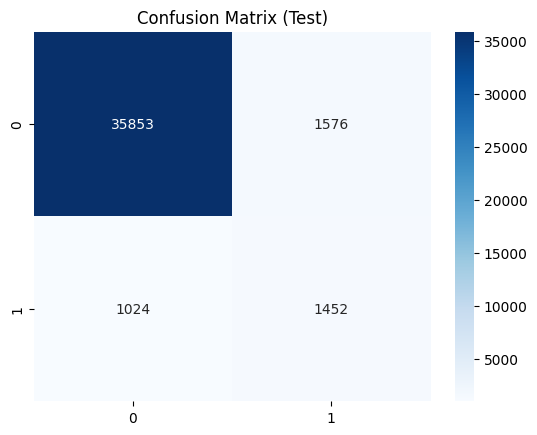

In [59]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix

test_probs = best_model.predict_proba(X_test_res)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)

print("Test F1:", f1_score(y_test, test_preds, sample_weight=w_test))
print("Test Precision:", precision_score(y_test, test_preds, sample_weight=w_test))
print("Test Recall:", recall_score(y_test, test_preds, sample_weight=w_test))
print("Test ROC-AUC:", roc_auc_score(y_test, test_probs, sample_weight=w_test))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_preds))

sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt='.0f', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.show()


In [68]:
log_search.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['major occupation code',
                                                   'class of worker',
                                                   'marital stat',
                                                   'tax filer stat',
                                                   'full or part time '
                                                   'employment stat',
                                                   'detailed household and '
                                                   'family stat',
                                                   'sex'])])),
                ('model',
                 LogisticRegression(C=np.float64(100.0),
                                    class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

In [60]:
rf_model = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ))
])

rf_params = {
    'model__n_estimators': [200, 400, 600],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    rf_model,
    rf_params,
    n_iter=30,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train, model__sample_weight=w_train)

best_model = rf_search.best_estimator_

print("Best CV F1:", rf_search.best_score_)


Best CV F1: 0.5077027465964377


In [61]:
from sklearn.metrics import f1_score
import numpy as np

val_probs = best_model.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = []

for t in thresholds:
    preds = (val_probs >= t).astype(int)
    f1 = f1_score(y_val, preds, sample_weight=w_val)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]

print("Best Threshold (Validation):", best_threshold)
print("Best Validation F1:", max(f1_scores))


Best Threshold (Validation): 0.6575757575757576
Best Validation F1: 0.5564928323399166


Test F1: 0.542055526784038
Test Precision: 0.5064018791784057
Test Recall: 0.5831098641950874
Test ROC-AUC: 0.9341459669541771

Confusion Matrix:
[[35947  1482]
 [ 1038  1438]]


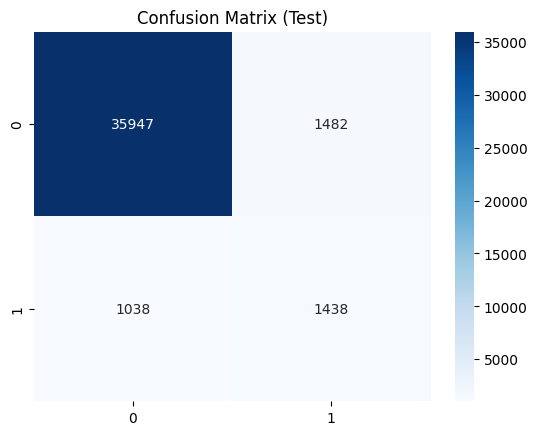

In [62]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix

test_probs = best_model.predict_proba(X_test)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)

print("Test F1:", f1_score(y_test, test_preds, sample_weight=w_test))
print("Test Precision:", precision_score(y_test, test_preds, sample_weight=w_test))
print("Test Recall:", recall_score(y_test, test_preds, sample_weight=w_test))
print("Test ROC-AUC:", roc_auc_score(y_test, test_probs, sample_weight=w_test))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_preds))

sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt='.0f', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.show()


In [ ]:
rf_search.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['major occupation code',
                                                   'class of worker',
                                                   'marital stat',
                                                   'tax filer stat',
                                                   'full or part time '
                                                   'employment stat',
                                                   'detailed household and '
                                                   'family stat',
                                                   'sex'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=2, n_estimators=600,
                                        random_state=42))])

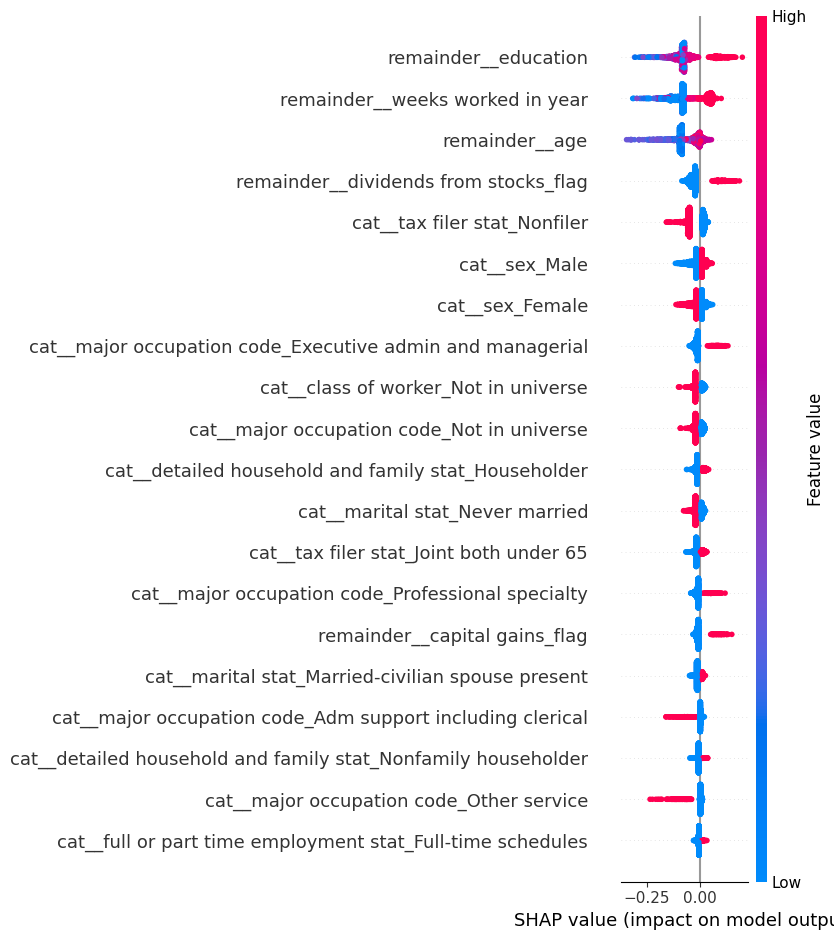

In [63]:
import shap
import numpy as np

# 1️⃣ Get trained pipeline
best_rf = rf_search.best_estimator_

# 2️⃣ Extract trained model + preprocessor
rf_model = best_rf.named_steps['model']
preprocessor = best_rf.named_steps['prep']

# 3️⃣ Transform test data
X_test_transformed = preprocessor.transform(X_test)

# Convert sparse → dense if needed
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# Force numeric
X_test_transformed = np.array(X_test_transformed, dtype=np.float64)

# 4️⃣ Get feature names
feature_names = preprocessor.get_feature_names_out()

# 5️⃣ Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Use sample to avoid slow computation
sample_idx = np.random.choice(len(X_test_transformed), 2000, replace=False)

X_sample = X_test_transformed[sample_idx]

shap_values = explainer.shap_values(X_sample)

if isinstance(shap_values, list):
    shap_values = shap_values[1]
elif len(shap_values.shape) == 3:
    shap_values = shap_values[:, :, 1]

shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names
)



In [64]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1️⃣ Define imbalance weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 2️⃣ Pipeline
xgb_model = Pipeline([
    ('prep', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,   # handles imbalance
        random_state=42,
        use_label_encoder=False
    ))
])

# 3️⃣ Hyperparameter grid
xgb_params = {
    'model__n_estimators': [400, 800, 1200],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.03, 0.05],
    'model__min_child_weight': [1, 5, 10],
    'model__subsample': [0.7, 0.85, 1.0],
    'model__colsample_bytree': [0.7, 0.85, 1.0],
    'model__gamma': [0, 1, 3],
    'model__reg_alpha': [0, 0.5, 1],
    'model__reg_lambda': [1, 5, 10]
}

# 4️⃣ Random Search
xgb_search = RandomizedSearchCV(
    xgb_model,
    xgb_params,
    n_iter=30,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 5️⃣ Fit on TRAIN only
xgb_search.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_

print("Best XGB CV F1:", xgb_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGB CV F1: 0.46616176425112277


In [65]:
from sklearn.metrics import f1_score
import numpy as np

val_probs = best_model.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = []

for t in thresholds:
    preds = (val_probs >= t).astype(int)
    f1 = f1_score(y_val, preds, sample_weight=w_val)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]

print("Best Threshold (Validation):", best_threshold)
print("Best Validation F1:", max(f1_scores))


Best Threshold (Validation): 0.6575757575757576
Best Validation F1: 0.5564928323399166


Test F1: 0.542055526784038
Test Precision: 0.5064018791784057
Test Recall: 0.5831098641950874
Test ROC-AUC: 0.9341459669541771

Confusion Matrix:
[[35947  1482]
 [ 1038  1438]]


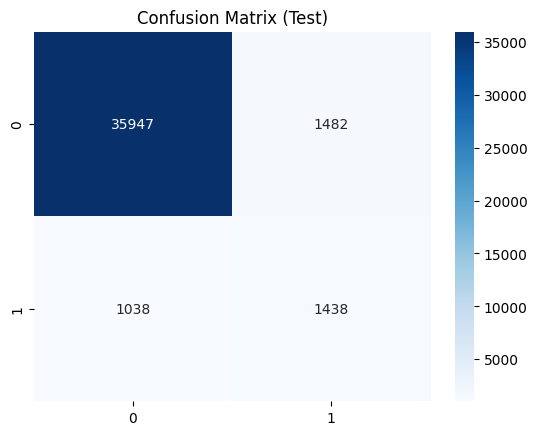

In [66]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix

test_probs = best_model.predict_proba(X_test)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)

print("Test F1:", f1_score(y_test, test_preds, sample_weight=w_test))
print("Test Precision:", precision_score(y_test, test_preds, sample_weight=w_test))
print("Test Recall:", recall_score(y_test, test_preds, sample_weight=w_test))
print("Test ROC-AUC:", roc_auc_score(y_test, test_probs, sample_weight=w_test))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_preds))

sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt='.0f', cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.show()


In [69]:
xgb_search.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['major occupation code',
                                                   'class of worker',
                                                   'marital stat',
                                                   'tax filer stat',
                                                   'full or part time '
                                                   'employment stat',
                                                   'detailed household and '
                                                   'family stat',
                                                   'sex'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_...
                               feature_types=None, gamma=3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=1200,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])